In [1]:
11140333/1e6

11.140333

# Coupler Spec

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
# from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
# dp = r'dataset_chevron.hdf5'
# dp = r'data_directory/20231210/20231210-010603-733-d6dce1-cz_chevron/dataset.hdf5'


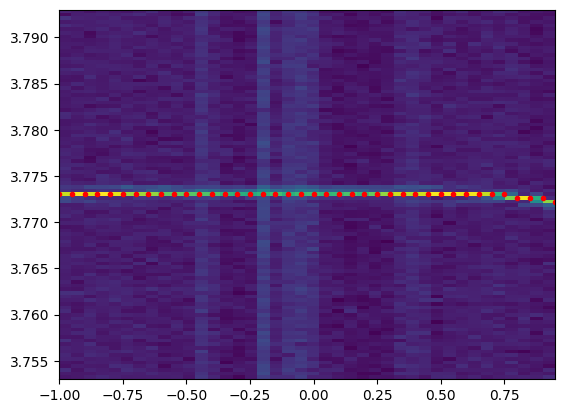

In [15]:

# dp = r'data_directory/20231213/20231213-111621-438-e0ddf9-coupler_spectroscopy/dataset.hdf5'
dp = r'data_directory/20240122/20240122-161245-412-42a533-coupler_spectroscopy/dataset.hdf5'
ds = load_dataset(dp)
qubit = 'q21'
freq = ds[f'spec_frequencies{qubit}'].values/1e9
dc2 = ds[f'dc_currents'].values*1e3
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
plt.imshow(magnitudes.T, aspect='auto', extent=[dc2[0], dc2[-1], freq[0], freq[-1]], origin='lower')
peaks = np.argmax(magnitudes, axis=1)
peak_freqs2 = freq[peaks]
plt.plot(dc2, peak_freqs2,'.', color='red')

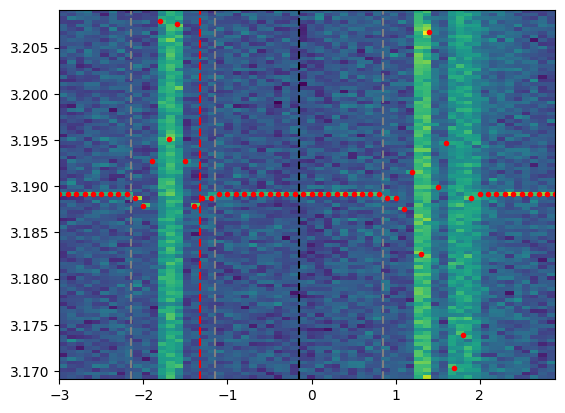

In [19]:
# dp = r'data_directory/20231213/20231213-111621-438-e0ddf9-coupler_spectroscopy/dataset.hdf5'
dp = r'data_directory/20240123/20240123-152211-445-892238-coupler_spectroscopy/dataset.hdf5'
ds = load_dataset(dp)
qubit = 'q16'
freq = ds[f'spec_frequencies{qubit}'].values/1e9
dc2 = ds[f'dc_currents'].values*1e3
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
plt.imshow(magnitudes.T, aspect='auto', extent=[dc2[0], dc2[-1], freq[0], freq[-1]], origin='lower')
peaks = np.argmax(magnitudes, axis=1)
plt.vlines(-2.15, freq[0], freq[-1], color='grey',linestyles='dashed')
plt.vlines(0.85, freq[0], freq[-1], color='grey',linestyles='dashed')
plt.vlines(-1.15, freq[0], freq[-1], color='grey',linestyles='dashed')
plt.vlines(-0.15, freq[0], freq[-1], color='black',linestyles='dashed')
plt.vlines(-1.330, freq[0], freq[-1], color='red',linestyles='dashed')
peak_freqs2 = freq[peaks]
plt.plot(dc2, peak_freqs2,'.', color='red')

[-1.3323, 1.0623]


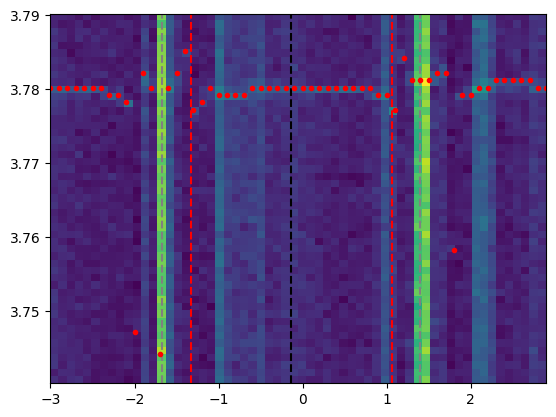

In [35]:
# dp = r'data_directory/20231213/20231213-111621-438-e0ddf9-coupler_spectroscopy/dataset.hdf5'
dp = r'data_directory/20240124/20240124-162444-058-e48e0e-coupler_spectroscopy/dataset.hdf5'
ds = load_dataset(dp)
qubit = 'q21'
freq = ds[f'spec_frequencies{qubit}'].values/1e9
dc2 = ds[f'dc_currents'].values*1e3
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
plt.imshow(magnitudes.T, aspect='auto', extent=[dc2[0], dc2[-1], freq[0], freq[-1]], origin='lower')
peaks = np.argmax(magnitudes, axis=1)
left,right = -1.67,1.4
full = left-right
zero = (left+right)/2
bias = [0.39*full+zero,-0.39*full+zero]
print(bias)
plt.vlines(left, freq[0], freq[-1], color='grey',linestyles='dashed')
plt.vlines(right, freq[0], freq[-1], color='grey',linestyles='dashed')
plt.vlines(zero, freq[0], freq[-1], color='black',linestyles='dashed')
plt.vlines(bias[0], freq[0], freq[-1], color='red',linestyles='dashed')
plt.vlines(bias[1], freq[0], freq[-1], color='red',linestyles='dashed')
peak_freqs2 = freq[peaks]
plt.plot(dc2, peak_freqs2,'.', color='red')

In [31]:
full = -1.67-1.4
zero = (-1.67+1.4)/2
print(full, zero)

-3.07 -0.135


In [21]:
(-0.15-(-1.330))/3

0.39333333333333337

In [13]:
-2.15-0.85

-3.0

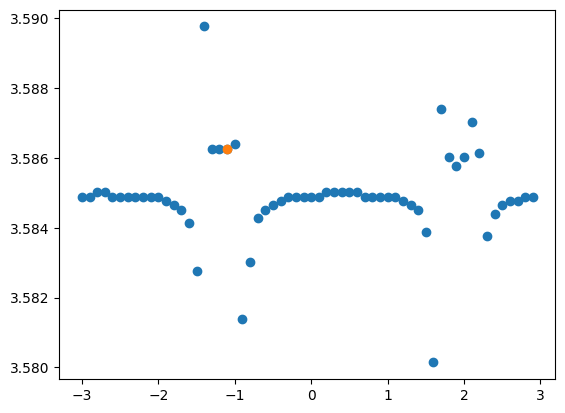

In [146]:
dp = r'data_directory/20231206/20231206-233435-108-60fa17-coupler_spectroscopy/dataset.hdf5'
ds = load_dataset(dp)
qubit = 'q13'
freq = ds[f'spec_frequencies{qubit}'].values/1e9
dc1 = ds[f'dc_currents'].values*1e3
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
peaks = np.argmax(magnitudes, axis=1)
peak_freqs1 = freq[peaks]
peak_freqs1[18:20] = peak_freqs1[17] 
idx = 19
plt.plot(dc1, peak_freqs1, 'o')
plt.plot(dc1[idx], peak_freqs1[idx], 'o')

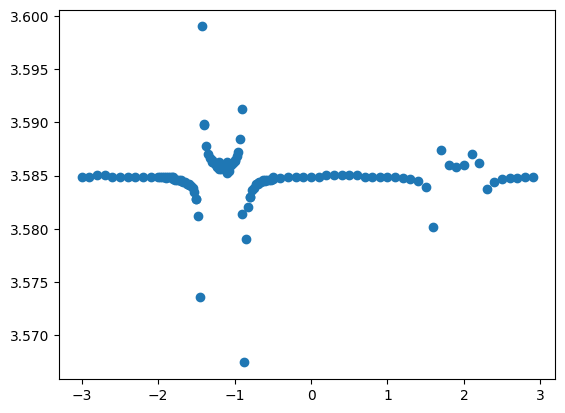

In [147]:
dc = np.concatenate((dc2, dc1))
peak_freqs = np.concatenate((peak_freqs2, peak_freqs1))
plt.plot(dc, peak_freqs, 'o')

In [144]:
import csv

row_list = np.transpose([dc, peak_freqs])

with open('coupler.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

In [180]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess
import numpy as np

# Cosine function that is fit to Rabi oscillations
def crossing(
    flux: float,
    wq: float,
    wc: float,
    # wd: float,
    g: float,
    # offset: float,
    # scale: float,
) -> float:
    # return wq-g/(wc*(np.cos(scale*flux+offset))**2+wd*(np.cos(scale*flux+offset))**4-wq)
    return wq-g**2/(wc*2*((np.cos(1*flux-0.43))**2)**0.5-wq)


class CouplerSpecModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(crossing, *args, **kwargs)

        # # Enforce oscillation frequency is positive
        # self.set_param_hint("frequency", min=0)
        # self.set_param_hint("duration", expr="1/frequency", vary=False)

        # # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        # self.set_param_hint("phase", value=0 ,min = 0, max = 6.28)

        # # Pi-pulse amplitude can be derived from the oscillation frequency
        # self.set_param_hint("swap", expr="duration/2-phase", vary=False)
        # self.set_param_hint("cz", expr="duration-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("flux", None)
        if drive_amp is None:
            return None

        # amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        # (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        # self.set_param_hint("scale", value=1.1)
        self.set_param_hint("g", value=0.05,min=0)
        self.set_param_hint("wq", value=offs_guess, min=0)
        self.set_param_hint("wc", value=6.7, min=0)
        # self.set_param_hint("offset", value=-0.3)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
g    0.02004        0      inf 0.003253     True     None     None
wc     6.867        0      inf  0.01502     True     None     None
wq     3.585        0      inf 0.0003741     True     None     None


(-1.9749999999999976, -0.5)

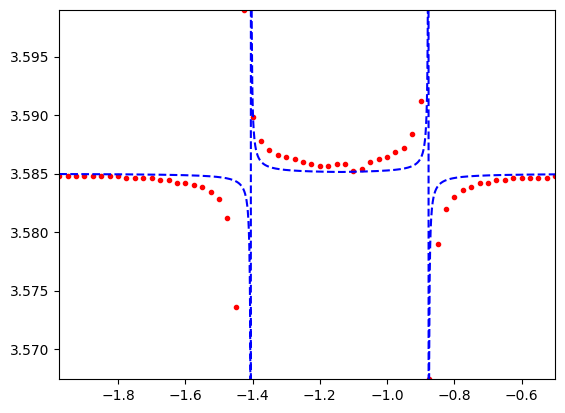

In [181]:
model = CouplerSpecModel()
# magnitude = magnitudes[-1]
fit_amplitudes = np.linspace( np.min(dc2), np.max(dc2), 2000)
guess = model.guess(peak_freqs2, flux=dc)
fit_result = model.fit(peak_freqs2, params=guess, flux=dc2)
fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
fit_result.params.pretty_print()
plt.plot(dc2,peak_freqs2,'.r')
plt.plot(fit_amplitudes,fit_y,'--b')
plt.ylim([min(peak_freqs),max(peak_freqs)])
plt.xlim([min(dc2),max(dc2)])
# plt.vlines(fit_result.params['cz'].value, min(peak_freqs), max(peak_freqs), colors='k', linestyles='dashed')

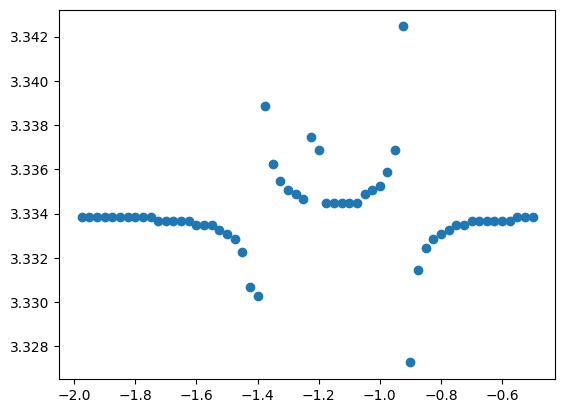

In [182]:
dp = r'data_directory/20231214/20231214-093251-044-789d19-coupler_spectroscopy/dataset.hdf5'
ds = load_dataset(dp)
qubit = 'q14'
freq = ds[f'spec_frequencies{qubit}'].values/1e9
dc = ds[f'dc_currents'].values*1e3
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
peaks = np.argmax(magnitudes, axis=1)
peak_freqs = freq[peaks]
plt.plot(dc, peak_freqs, 'o')

In [ ]:
import csv

row_list = np.transpose([dc, peak_freqs])

with open('coupler_q14.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

# Chevron

In [73]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess
import numpy as np

# Cosine function that is fit to Rabi oscillations
def cos_func(
    drive_amp: float,
    frequency: float,
    amplitude: float,
    offset: float,
    phase: float,
) -> float:
    return amplitude * np.cos(2 * np.pi * (frequency * (drive_amp)) + phase) + offset

class ChevronModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(cos_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)
        self.set_param_hint("duration", expr="1/frequency", vary=False)

        # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        self.set_param_hint("phase", value=0 ,min = 0, max = 6.28)

        # Pi-pulse amplitude can be derived from the oscillation frequency
        self.set_param_hint("swap", expr="duration/2-phase", vary=False)
        self.set_param_hint("cz", expr="duration-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("drive_amp", None)
        if drive_amp is None:
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=0)
        self.set_param_hint("offset", value=offs_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude   0.06517        0      inf  0.01787     True     None     None
cz            913.3     -inf      inf    194.2    False duration-phase     None
duration      918.7     -inf      inf    194.8    False 1/frequency     None
frequency  0.001088        0      inf 0.0002309     True     None     None
offset       0.6053     -inf      inf  0.01348     True     None     None
phase         5.379        0     6.28   0.6854     True     None     None
swap            454     -inf      inf    96.81    False duration/2-phase     None


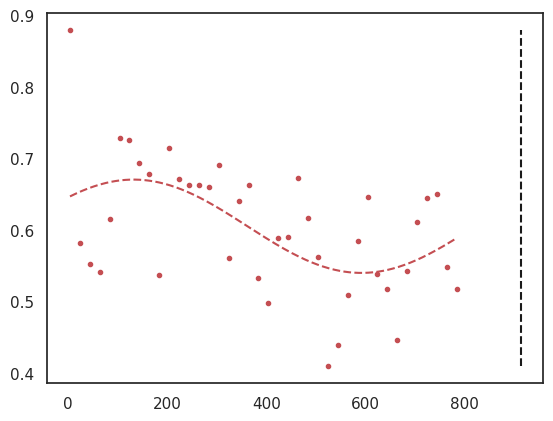

In [74]:
model = ChevronModel()
magnitude = magnitudes[-1]
fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
guess = model.guess(magnitude, drive_amp=amp)
fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
fit_result.params.pretty_print()
plt.plot(amp,magnitude,'.r')
plt.plot(fit_amplitudes,fit_y,'--r')
plt.vlines(fit_result.params['cz'].value, min(magnitude), max(magnitude), colors='k', linestyles='dashed')

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
# from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
# dp = r'dataset_chevron.hdf5'
# dp = r'data_directory/20231210/20231210-010603-733-d6dce1-cz_chevron/dataset.hdf5'
dp = r'data_directory/20231210/20231210-123832-340-338e7f-cz_chevron/dataset.hdf5'
ds = load_dataset(dp)

451.85 241.6331795621898


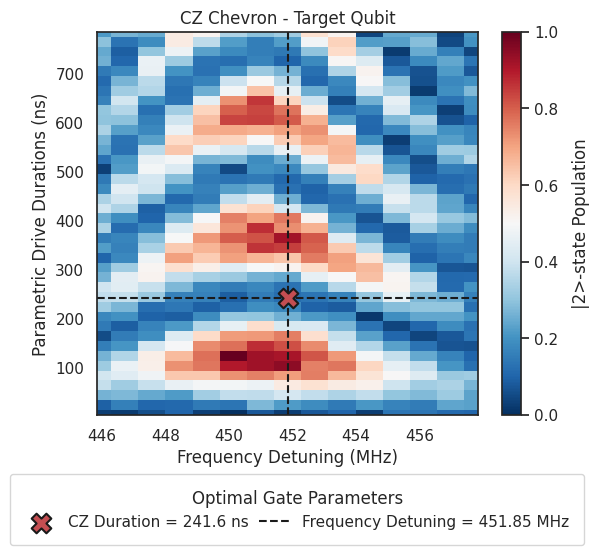

457.85 913.3295104551909


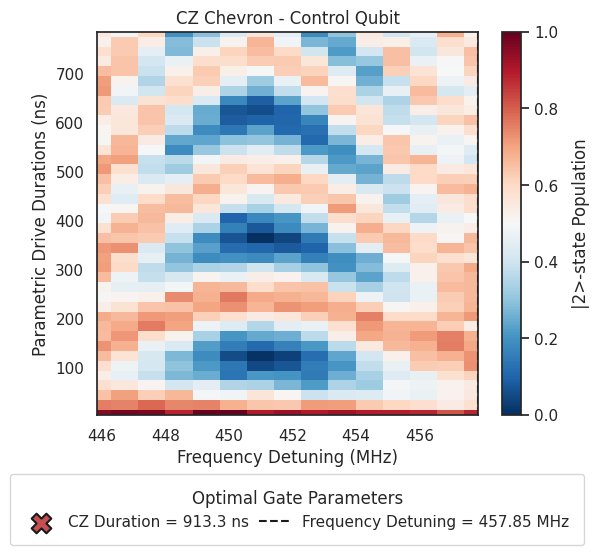

In [76]:
for qubit in ['q13','q14']:
    freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
    amp = ds[f'cz_pulse_durations{qubit}'].values*1e9
    magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
    magnitudes = np.transpose((magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes)))
    fit_results = []
    for magnitude in magnitudes:
        model = ChevronModel()
        # magnitude = np.transpose(values)[15]
        fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
        guess = model.guess(magnitude, drive_amp=amp)
        fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
        fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
        fit_results.append(fit_result)
        # plt.plot(y,magnitude,'.r')
        # plt.plot(fit_amplitudes,fit_y,'--b')
    qois = np.transpose([[np.abs(fit.result.params[p].value) for p in ['amplitude','duration']] for fit in fit_results])
    # print(qois)
    qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
    opt_id = np.argmax(np.prod(qois,axis=1))
    if int(qubit[1:]) % 2 == 0:
        # opt_id = np.argmax(np.sum(qois,axis=1))
        qubit_type = 'Control'
    else:
        # opt_id = np.argmin(np.diff(qois,axis=1))
        qubit_type = 'Target'
    opt_freq = freq[opt_id]
    opt_cz = fit_results[opt_id].result.params['cz'].value
    opt_swap = fit_results[opt_id].result.params['swap'].value
    opt_id,opt_freq,opt_cz,opt_swap
    print(opt_freq,opt_cz)
    import seaborn as sns
    sns.set_theme(style="white")
    %matplotlib inline
    plt.figure(figsize=(6,6))
    fig = plt.pcolormesh(freq,amp,np.transpose(magnitudes),shading='nearest',cmap='RdBu_r')
    plt.scatter(opt_freq,opt_cz,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
    # plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
    plt.vlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
    plt.hlines(opt_cz,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

    plt.legend(loc = 'lower center', bbox_to_anchor=(-0.25, -0.36, 1.55, .102), mode='expand', ncol=2,
                title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
    # plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
    #                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
    cbar = plt.colorbar(fig)
    cbar.set_label('|2>-state Population', labelpad=10)
    plt.xlim([freq[0],freq[-1]])
    plt.ylim([amp[0],amp[-1]])
    plt.ylabel('Parametric Drive Durations (ns)')
    plt.xlabel('Frequency Detuning (MHz)')
    plt.title(f'CZ Chevron - {qubit_type} Qubit')
    plt.tight_layout()
    plt.savefig(f'CZ Chevron {qubit}.png',dpi=300)
    plt.show()

#  Rabi

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
dp = r'dataset_rabi.hdf5'
ds = load_dataset(dp)
ds

<xarray.Dataset>
Dimensions:           (mw_amplitudesq16: 51, ReIm: 2, mw_amplitudesq17: 51,
                       mw_amplitudesq18: 51, mw_amplitudesq19: 51,
                       mw_amplitudesq20: 51, mw_amplitudesq21: 51,
                       mw_amplitudesq22: 51, mw_amplitudesq23: 51,
                       mw_amplitudesq24: 51, mw_amplitudesq25: 51)
Coordinates:
  * mw_amplitudesq16  (mw_amplitudesq16) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq17  (mw_amplitudesq17) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq18  (mw_amplitudesq18) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq19  (mw_amplitudesq19) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq20  (mw_amplitudesq20) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq21  (mw_amplitudesq21) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq22  (mw_amplitudesq22) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq23  (mw_amplitudesq23) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq24  (mw_amplitudesq24) float64 0.002 0.00896 ... 0.343 0.35
  * mw_amplitudesq25  (mw_amplitudesq25) float64 0.002 0.00896 ... 0.343 0.35
Dimensions without coordinates: ReIm
Data variables:
    yq16              (mw_amplitudesq16, ReIm) float64 0.007948 ... 0.01638
    yq17              (mw_amplitudesq17, ReIm) float64 0.001115 ... -0.005955
    yq18              (mw_amplitudesq18, ReIm) float64 -0.00679 ... -0.01324
    yq19              (mw_amplitudesq19, ReIm) float64 0.003841 ... 0.009994
    yq20              (mw_amplitudesq20, ReIm) float64 0.008832 ... 0.01463
    yq21              (mw_amplitudesq21, ReIm) float64 0.007493 ... 0.01152
    yq22              (mw_amplitudesq22, ReIm) float64 -0.001018 ... -0.01253
    yq23              (mw_amplitudesq23, ReIm) float64 -0.008172 ... -0.00523
    yq24              (mw_amplitudesq24, ReIm) float64 0.006656 ... 0.01127
    yq25              (mw_amplitudesq25, ReIm) float64 0.006963 ... -0.01421
Attributes:
    name:     rabi_oscillations
    tuid:     20231116-164108-774-f880a9-rabi_oscillations

In [21]:
ref={}
qubits = ['q21','q22']
for qubit in qubits:
    magnitudes = np.array([np.linalg.norm(v) for v in ds[f'y{qubit}']])
    # print(magnitudes)
    # magnitudes = np.transpose((magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes)))
    ref[qubit] = {'min':np.min(magnitudes),'max':np.max(magnitudes)}

# CZ

In [22]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess
import numpy as np

# Cosine function that is fit to Rabi oscillations
def cos_func(
    drive_amp: float,
    frequency: float,
    amplitude: float,
    offset: float,
    phase: float = 0,
) -> float:
    return amplitude * np.cos(2 * np.pi * frequency * (drive_amp + phase)) + offset

class CZModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(cos_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)

        # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        self.set_param_hint("phase", min = 0, max = 360)

        # Pi-pulse amplitude can be derived from the oscillation frequency

        # self.set_param_hint("swap", expr="1/(2*frequency)-phase", vary=False)
        self.set_param_hint("cz", expr="2/(2*frequency)-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("drive_amp", None)
        if drive_amp is None:
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=0)
        self.set_param_hint("offset", value=offs_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
# from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
dp = r'dataset_cz.hdf5'
ds = load_dataset(dp)
ds

<xarray.Dataset>
Dimensions:           (ramsey_phasesq21: 41, control_onsq21: 2, ReIm: 2,
                       ramsey_phasesq22: 41, control_onsq22: 2)
Coordinates:
  * ramsey_phasesq21  (ramsey_phasesq21) float64 0.0 18.0 36.0 ... 702.0 720.0
  * ramsey_phasesq22  (ramsey_phasesq22) float64 0.0 18.0 36.0 ... 702.0 720.0
  * control_onsq21    (control_onsq21) bool False True
  * control_onsq22    (control_onsq22) bool False True
Dimensions without coordinates: ReIm
Data variables:
    yq21              (ramsey_phasesq21, control_onsq21, ReIm) float64 0.0075...
    yq22              (ramsey_phasesq22, control_onsq22, ReIm) float64 0.0051...
Attributes:
    name:     cz_calibration
    tuid:     20231116-222957-003-bbbdae-cz_calibration

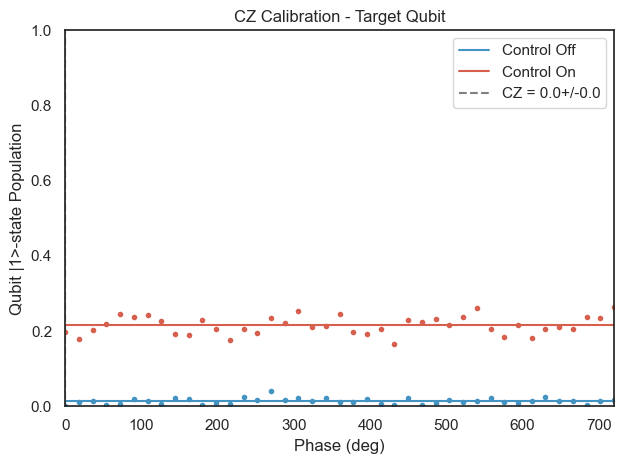

[[[273.57402764 113.50264822]]

 [[  0.77594685   2.1447072 ]]]


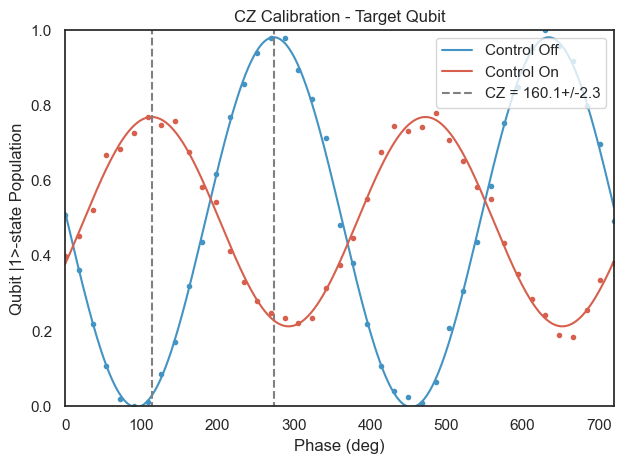

In [27]:
for qubit in ['q21','q22']:
    freq = ds[f'control_ons{qubit}'].values
    amp = ds[f'ramsey_phases{qubit}'].values
    magnitudes =np.transpose([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])

    # print(magnitudes)
    if int(qubit[1:]) % 2 == 0:
        ref_min,ref_max = np.min(magnitudes),np.max(magnitudes)
        qubit_type = 'Target'
    else:
        ref_min,ref_max = np.min(magnitudes),ref[qubit]['max']
        qubit_type = 'Control'
    magnitudes = (magnitudes - ref_min)/(ref_max-ref_min)

    fit_results,fit_ys = [],[]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    for magnitude in magnitudes:
        if int(qubit[1:]) % 2 == 0:
            fit = True
            model = CZModel()
            # magnitude = np.transpose(values)[15]
            guess = model.guess(magnitude, drive_amp=amp)
            fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
            fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
            fit_results.append(fit_result)
        else:
            fit = False
            fit_y = [np.mean(magnitude)]*400
        fit_ys.append(fit_y)
    if fit:
        qois = np.transpose([[[fit.result.params[p].value,fit.result.params['cz'].stderr] for p in ['cz']] for fit in fit_results])
        opt_cz = qois[0][0]
        cphase = 180-np.abs(np.abs(np.diff(opt_cz))[0]-180)
        err = np.sqrt(np.sum(np.array(qois[1][0])**2))
        
    else:
        cphase = 0
        err = 0
        opt_cz = [0]*2

    label = ['Control Off','Control On']
    x = range(len(label))
    colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 0.8, len(x)))

    for index,magnitude in enumerate(magnitudes):
        plt.plot(amp,magnitude,'.',c = colors[index])
        plt.plot(fit_amplitudes,fit_ys[index],'-',c = colors[index],label = label[index])
        plt.vlines(opt_cz[index],-10,10,colors='gray',linestyles='--',linewidth=1.5)

    plt.vlines(0,-10,-10,colors='gray',linestyles='--', label = 'CZ = {:.1f}+/-{:.1f}'.format(cphase,err),zorder=-10)
    plt.legend(loc = 'upper right')
    plt.xlim([amp[0],amp[-1]])
    plt.ylim(0,1)
    plt.xlabel('Phase (deg)')
    plt.ylabel('Qubit |1>-state Population')
    plt.title(f'CZ Calibration - Target Qubit')
    plt.tight_layout()
    plt.savefig(f'CZ calibration {qubit}.png',dpi=300)
    plt.show()

# Dynamic Phase

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
# from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
dp = r'dataset_dynamic.hdf5'
ds = load_dataset(dp)
ds

<xarray.Dataset>
Dimensions:           (ramsey_phasesq21: 41, control_onsq21: 2, ReIm: 2,
                       ramsey_phasesq22: 41, control_onsq22: 2)
Coordinates:
  * ramsey_phasesq21  (ramsey_phasesq21) float64 0.0 18.0 36.0 ... 702.0 720.0
  * ramsey_phasesq22  (ramsey_phasesq22) float64 0.0 18.0 36.0 ... 702.0 720.0
  * control_onsq21    (control_onsq21) bool False True
  * control_onsq22    (control_onsq22) bool False True
Dimensions without coordinates: ReIm
Data variables:
    yq21              (ramsey_phasesq21, control_onsq21, ReIm) float64 0.0072...
    yq22              (ramsey_phasesq22, control_onsq22, ReIm) float64 0.0086...
Attributes:
    name:     cz_calibration
    tuid:     20231116-220108-409-5d7766-cz_calibration

In [76]:
ds = ds.assign_attrs({'edge_gourp': 1})
ds = ds.assign_attrs({'experiment_type': 'dynamic_phase'})
ds = ds.assign_attrs({'name': 'cz_dynamic_phase'})
ds

<xarray.Dataset>
Dimensions:           (ramsey_phasesq21: 41, control_onsq21: 2, ReIm: 2,
                       ramsey_phasesq22: 41, control_onsq22: 2)
Coordinates:
  * ramsey_phasesq21  (ramsey_phasesq21) float64 0.0 18.0 36.0 ... 702.0 720.0
  * ramsey_phasesq22  (ramsey_phasesq22) float64 0.0 18.0 36.0 ... 702.0 720.0
  * control_onsq21    (control_onsq21) bool False True
  * control_onsq22    (control_onsq22) bool False True
Dimensions without coordinates: ReIm
Data variables:
    yq21              (ramsey_phasesq21, control_onsq21, ReIm) float64 0.0072...
    yq22              (ramsey_phasesq22, control_onsq22, ReIm) float64 0.0086...
Attributes:
    name:             cz_dynamic_phase
    tuid:             20231116-220108-409-5d7766-cz_calibration
    edge_gourp:       1
    experiment_type:  dynamic_phase

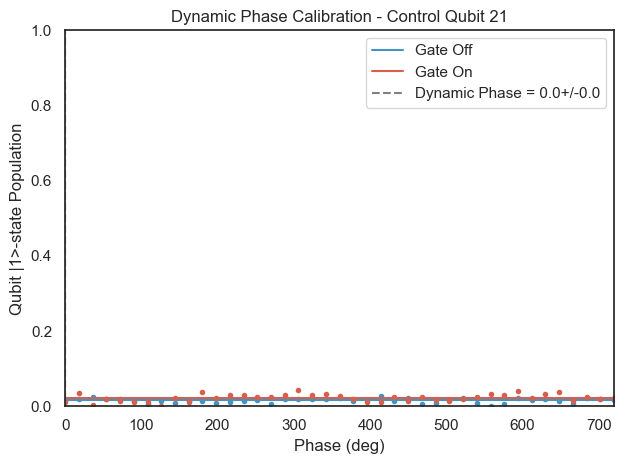

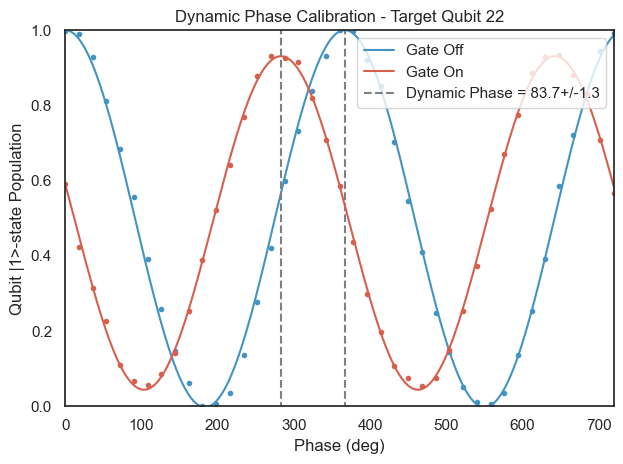

In [81]:
dynamic = ds.attrs['name']  == 'cz_dynamic_phase'
for qubit in ['q21','q22']:
    freq = ds[f'control_ons{qubit}'].values
    amp = ds[f'ramsey_phases{qubit}'].values
    magnitudes =np.transpose([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])

    # print(magnitudes)
    if int(qubit[1:]) % 2 == 0:
        ref_min,ref_max = np.min(magnitudes),np.max(magnitudes)
        qubit_type = 'Target'
    else:
        ref_min,ref_max = np.min(magnitudes),ref[qubit]['max']
        qubit_type = 'Control'
    magnitudes = (magnitudes - ref_min)/(ref_max-ref_min)

    fit_results,fit_ys = [],[]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    for magnitude in magnitudes:
        if int(qubit[1:]) % 2 == 0:
            fit = True
            model = CZModel()
            # magnitude = np.transpose(values)[15]
            guess = model.guess(magnitude, drive_amp=amp)
            fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
            fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
            fit_results.append(fit_result)
        else:
            fit = False
            fit_y = [np.mean(magnitude)]*400
        fit_ys.append(fit_y)
    if fit:
        qois = np.transpose([[fit.result.params[p].value,fit.result.params['cz'].stderr] for p in ['cz'] for fit in fit_results])
        opt_cz = qois[0]
        cphase = 180-np.abs(np.abs(np.diff(opt_cz))[0]-180)
        err = np.sqrt(np.sum(np.array(qois[1])**2))
        
    else:
        cphase = 0
        err = 0
        opt_cz = [0]*2
    if dynamic:
        label = ['Gate Off','Gate On']
        name = 'Dynamic Phase'
    else:
        label = ['Control Off','Control On']
        name = 'CZ'
    x = range(len(label))
    colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 0.8, len(x)))

    for index,magnitude in enumerate(magnitudes):
        plt.plot(amp,magnitude,'.',c = colors[index])
        plt.plot(fit_amplitudes,fit_ys[index],'-',c = colors[index],label = label[index])
        plt.vlines(opt_cz[index],-10,10,colors='gray',linestyles='--',linewidth=1.5)

    plt.vlines(0,-10,-10,colors='gray',linestyles='--', label = '{:} = {:.1f}+/-{:.1f}'.format(name,cphase,err),zorder=-10)
    plt.legend(loc = 'upper right')
    plt.xlim([amp[0],amp[-1]])
    plt.ylim(0,1)
    plt.xlabel('Phase (deg)')
    plt.ylabel('Qubit |1>-state Population')
    plt.title(f'{name} Calibration - {qubit_type} Qubit {qubit[1:]}')
    plt.tight_layout()
    plt.savefig(f'{name} Calibration {qubit}.png',dpi=300)
    plt.show()

# Backup

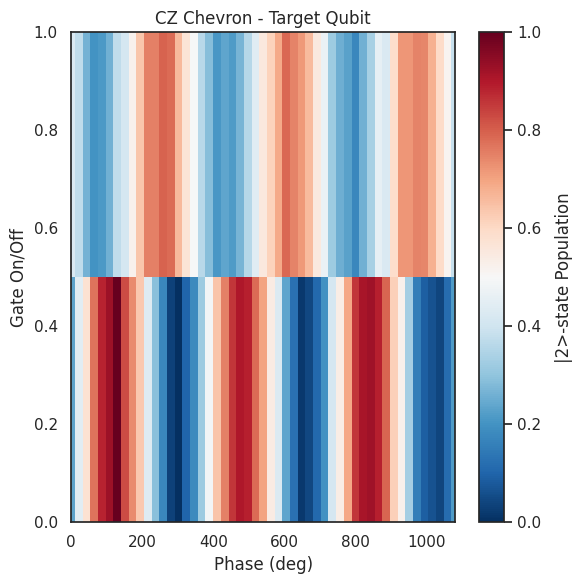

In [196]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
plt.figure(figsize=(6,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
# plt.scatter(opt_cz,opt_freq,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
# plt.vlines(opt_cz,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.15, -0.36, 1.4, .102), mode='expand', ncol=2,
#             title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('|2>-state Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Phase (deg)')
plt.ylabel('Gate On/Off')
plt.title(f'CZ Chevron - Target Qubit')
plt.tight_layout()
plt.savefig(f'CZ calibration {qubit}.png',dpi=300)
plt.show()

In [ ]:
qubit = 'q22'
freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
amp = ds[f'cz_pulse_durations{qubit}'].values*1e9
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = (magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes))

In [ ]:
fit_results = []
for magnitude in magnitudes:
    model = ChevronModel()
    # magnitude = np.transpose(values)[15]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    guess = model.guess(magnitude, drive_amp=amp)
    fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
    fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
    fit_results.append(fit_result)
    # plt.plot(y,magnitude,'.r')
    # plt.plot(fit_amplitudes,fit_y,'--b')
qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
opt_id = np.argmax(np.sum(qois,axis=1))
opt_freq = freq[opt_id]
opt_cz = fit_results[opt_id].result.params['cz'].value
opt_swap = fit_results[opt_id].result.params['swap'].value
opt_id,opt_freq,opt_cz,opt_swap

(11, -0.575, 1067.676579708564, 534.0882898578424)

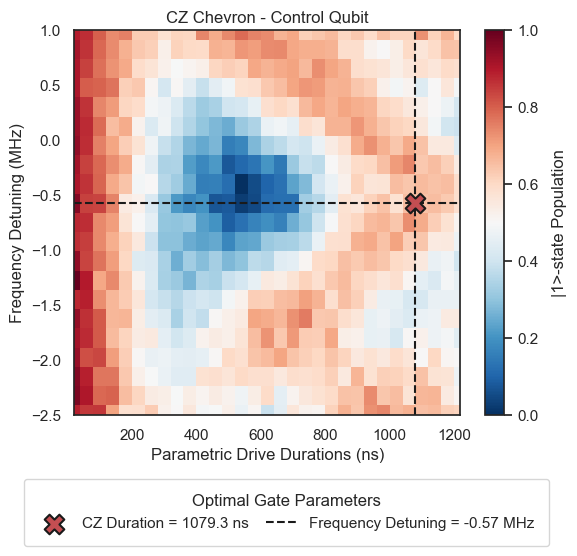

In [ ]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
plt.figure(figsize=(6,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
plt.scatter(opt_cz_q21,opt_freq,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz_q21),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
plt.vlines(opt_cz_q21,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

plt.legend(loc = 'lower center', bbox_to_anchor=(-0.15, -0.36, 1.4, .102), mode='expand', ncol=2,
            title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('|1>-state Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Parametric Drive Durations (ns)')
plt.ylabel('Frequency Detuning (MHz)')
plt.title(f'CZ Chevron - Control Qubit')
plt.tight_layout()
plt.savefig(f'CZ Chevron {qubit}.png',dpi=300)
plt.show()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude    0.1402  -0.5022      inf   0.0179     True     None     None
cz             1031     -inf      inf    146.4    False 2/(2*frequency)-phase     None
frequency  0.0009703        0      inf 6.47e-05     True     None     None
offset       0.5913     -inf      inf  0.01383     True     None     None
phase          -0.5     -0.5      0.5    81.92     True     None     None
swap          515.8     -inf      inf    113.5    False 1/(2*frequency)-phase     None


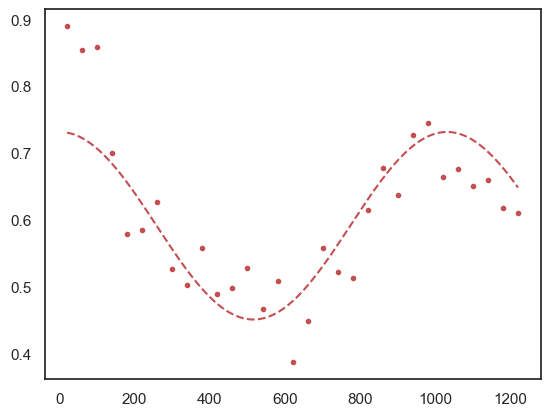

In [ ]:
# model = ChevronModel()
# magnitude = magnitudes[0]
# fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
# guess = model.guess(magnitude, drive_amp=amp)
# fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
# fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
# fit_result.params.pretty_print()
# plt.plot(amp,magnitude,'.r')
# plt.plot(fit_amplitudes,fit_y,'--r')